# 8-Point Algorithm Scene Reconstruction Demo

Written by Arisa Cowe and Collin Kariuki for CS153

## Introduction

Within the growing field of computer vision, depth/3D-reconstruction is a topic that particularly stands out for its promising applications in computer-aided visualization, augmented and virtual reality, and human computer interaction/experience design among many others. Given how it has demonstrated its utility in tools such as [Phillips SmartCT](https://www.usa.philips.com/healthcare/product/HCNCVC846/smartct-3d-visualization-and-measurement-solution) or [Google Earth](https://www.google.com/earth/index.html), it stands to reason that 3D-reconstruction softwares and technologies will continue to be pursued by many scientists, engineers, and technicians alike. Moreover, the significance of the 8-point algorithm at large may ensure that ego-motion (the motion of a camera or a mobile robot relative to its environment) is smooth. For ego-motion, to work a stereo-sequence needs to be used to create a 3D representation of the scene which is generally based on the principle of the triangulation (which we'll talk about in depth in this notebook). In the grand scope of things, applications of ego-motion estimation include autonomous navigation of mobile robots which can be used to navigate inhospitable environments [StereoScan: Dense 3d Reconstruction in Real-time](https://ieeexplore.ieee.org/document/5940405). However, this topic presents many barriers to entry with its numerous equipment, architecture, and software specifications, making it difficult for newcomers in computer vision to utilize these existing approaches. Thus, we aim to ease the learning curve by offering a guided implementation of one reconstruction method, the Eight-Point Algorithm, in this notebook. This hopefully supports a broader range hardware, software, and technical specifications. Our methodology and the relevant mathematical concepts are described within the code demonstration below. 

## Demo Process

This notebook will go through the process of obtaining 3D coordinates from a 2D image using the 8-point algorithm. In particular, we outline process as follows:
1. **Keypoint Matching**: Here, we set up the SIFT keypoint matching to be utilized in our 3D cordinate calculations. 
2. **Fundamental Matrix Construction**: Using our feature coordinates and the Eight-point algorithm, we construct a linear system representation of motion between our two frames, the fundamental matrix.
3. **Triangulation**: Using the fundamental matrix, we find the 3D coordinate associated with our 2D feature points. 


## Section 1: Set-up of Images and Feature Matches

We load in our two frame images and obtain their feature matches using feature matching as implemented in the CS153 in-class Keypoint Demo notebook.

In [2]:
# Import all necessary libraries
import cv2
import matplotlib.pyplot as plt
import math as m
import numpy as np
import numpy.matlib as npm
import os
from glob import glob

#%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 10] # matplotlib setting to control the size of display images

In [3]:
# Image loading code
def load_img(input_str):
    img_raw = cv2.imread(input_str)
    img_detect = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)
    img_display = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    
    return img_detect, img_display

In [4]:
# Feel free to replace this with your own images!
# img_det1, img_display1 = load_img('Hive_Bottle_3.jpg')
# img_det2, img_display2 = load_img('Hive_Bottle_4.jpg')

img_det1, img_display1 = load_img('table_stuff3.png')
img_det2, img_display2 = load_img('table_stuff4.png')

# Display images we're working with
plt.subplot(1,2,1)
plt.imshow(img_display1)
#plt.show()
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(img_display2)
#plt.show()
plt.axis('off')

error: OpenCV(4.5.2) ../modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


(-0.5, 3023.5, 4031.5, -0.5)

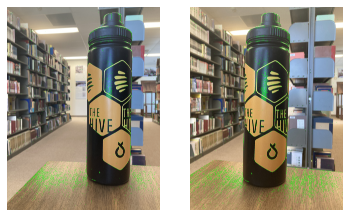

In [4]:
# Use keypoint matcher of your choice (Default is ORB)
#descriptor=cv2.ORB_create()
descriptor = cv2.SIFT_create()

# We store the matcher type for later
matcher_type = 'sift' 
    

kpts1, feats1 = descriptor.detectAndCompute(img_det1, None)
kpts2, feats2 = descriptor.detectAndCompute(img_det2, None)

# Display the keypoint matches found
plt.subplot(1,2,1)
plt.imshow(cv2.drawKeypoints(img_display1,kpts1,None,color=(0,255,0)))
#plt.show()
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.drawKeypoints(img_display2,kpts2,None,color=(0,255,0)))
#plt.show()
plt.axis('off')

(-0.5, 6047.5, 4031.5, -0.5)

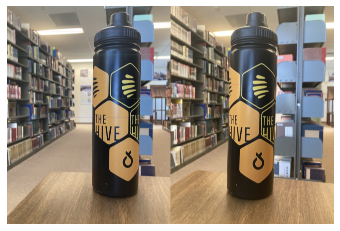

In [5]:
# Set up brute force matcher to establish matches between images

matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True) # matcher for SIFT
#matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # matcher for ORB

matches = matcher.match(feats1,feats2)
sorted_matches = sorted(matches, key=lambda x:x.distance) # sort distances

num_keep = 8 # Keep the top 8-9 best matching lines

matched_img = cv2.drawMatches(img_display1, kpts1, img_display2, kpts2, sorted_matches[:num_keep], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_img)
plt.axis('off')

(-0.5, 6047.5, 4031.5, -0.5)

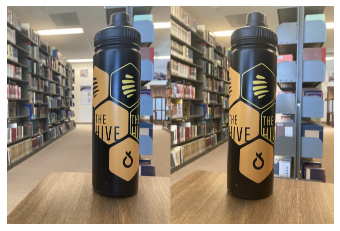

In [6]:
# We select one match within our best matches to represent the feature point 
# that we are finding the 3D-coordinate for

i = 3
one_match_img = cv2.drawMatches(img_display1, kpts1, img_display2, kpts2, [sorted_matches[i]], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(one_match_img)
plt.axis('off')

...and that completes our set up for now.

## Section 2: Finding the Fundamental Matrix

This section is broken down into two parts. 
In **Part 1**, we introduce the relevant mathematics that guide our reconstruction process, where we explain what the fundamental matrix is as well as what motivates the implementation and use of the 8-point algorithm for reconstructive purposes. 
Meanwhile, in **Part 2**, we implement our own version of the 8-point algorithm to find the fundamental matrix, $\textbf{F}$.

### 2.1: Mathematical Motivations

In this part, we set the scene with some basic epipolar geometry and then immediately dive straight into a bunch of corresponding linear algebra, setting up core motivation behind the 8-point algorithm.

This part is heavily based on CMU Professor Kris Kitani's Computer Vision lecture slides on structure from motion (**Lectures 9.1 - 9.4**), which can be accessed here: https://www.cs.cmu.edu/~16385/s17/, alongside **Section 11.3** of Richard Szeliski's *Computer Vision Algorithms and Applications*.

### A quick and dirty dive into epipolar geometry

Suppose we have two observers (people, eyes, sentient cameras, you name it) looking at the same thing from afar. The two want to guess how far away it is without moving from their current positions. How might they be able to do so?

One way might be to use **epipolar geometry**.

We can visualize the scenario above like so:
<img src="epipolar_setup.jpg" width="40%" height="40%">

where $\textbf{c}_0$ and $\textbf{c}_1$ are the two observers and $\textbf{p}$ is the point object that the two are looking at. The two rectangular planes being "projected" from either observer is representative of their current viewframe, with $\textbf{x}_0$ being the place where $c_0$ sees $p$ from their view and and $\textbf{x}_1$ the place where $c_1$ sees $p$ from their view. If the observers can see each other in their viewframe, i.e. $c_0$ sees $c_1$ at $\textbf{e}_0$ and $c_1$ sees $c_0$ at epipole $\textbf{e}_1$ , then on either viewframe, the $\textbf{l}_i$, $i \in \{0,1\}$, can be formed between the point $x_i$ where the object is seen and the point $x_i$ where the other observer $c_j$, $j \in \{0,1\}, j \neq i$ is seen by $c_i$. 

The points $e_0,e_1$ where one observer sees the other in their viewpoint are known as the **epipoles**
while the lines $l_0,l_1$, which encode information about hour far either observer $c_i$ sees $c_j$ is from $p$ in their viewframe, are known as **epipolar lines**. 

From our epipolar lines, we can construct a plane that contains $p$, $c_0$, and $c_1$ and cuts though both viewframes at lines $l_0$ and $l_1$ respectively. This plane establishes an **epipolar constraint** which dictates there must be two lines, one parallel to $l_1$ that passes through $x_0$ and another parallel to $l_0$ that passes through $x_1$, whose intersection is at $p$. These new lines encode information about the actual distance between either observer and $p$ from which a relative depth coordinate $z$ can be obatined. Thus, should the relative positions of the two observers be known, we can find where $p$ is coordinate-wise using triangluation, which is to be discussed in more detail within the triangulation section.

### And then there was one...

The above scenario established the existence of two observers viewing the same distant point at the same time (i.e. we had a **stereo** set-up). But what happens if one of our observers disappears from the scene? (i.e. we now have a **monocular** set-up) How do we get our epipolar setup from above?

Fret not! If the point we are observing is static (i.e. the point/object remains in place), then so long as our remaining observer has the ability to move positions, and the time to do so, we can change the above setup so that $c_0$ reflects the position from which the observer was looking at $p$ at time $t_0$ and $c_1$ the position from which the observer was looking at $p$ at time $t_1$. That is, our "two" observers are just the same observer looking at the object from two diffrent positions at seperate instances of time, i.e. we utilze a *structure from motion* approach to determine the 3D form and location of scenic elements.

With this change in set up, we can represent the relative positions between the two observer instances as the rotation $\textbf{R}$ (a matrix) and translation $\textbf{t}$ (a vector) taken to get from one position to the other. From this, we can encode the epipolar geometry above as a linear operator $\textbf{E}$ where

<font size="5">
    $$\textbf{E} = [\textbf{t}]_\times\textbf{R},$$ 
</font> 

and

<font size="5">
    $$\textbf{Ex}_i = \textbf{l}_j,$$
</font> 

i.e. applying $\textbf{E}$ on $x_i$ yields the epipolar line in the other frame $l_j$. $\textbf{E}$ is known as the **essential matrix**. (More information on the above derivation can be found in section 11.3 of Szeliski's textbook)

Should the exact scene metric be unknown, we can instead use the **fundamental matrix** $\textbf{F}$, the uncalibrated version of the essential matrix, to encode the epipolar geometry above, which which is what we will be computing for in this demo using the 8-point algorithm. 

### Finding F 

Given $n$ homogenous (2D) feature correspondences of the form $\textbf{x}_m=[x_0,y_0,1]^T$ and $\textbf{x}'_m=[x_1,y_1,1]^T$ from above, how can we get the 3 by 3 $F$ matrix ? 

Recall that $\textbf{E}$ is a linear operator formed by performing a cross product of $\textbf{t}$ and $\textbf{R}$ via cross product operator on $\textbf{t}$. Since the rotation and translation is happening on the plane, then $\textbf{Ex} = \textbf{l}'$ could be interepreted as an vector representation of line $\textbf{l}'$ that is orthogonal to the plane. It immediately follows then that 

<font size="5">
    $$\textbf{x'}_m ^T\textbf{l}'_m = 0,$$
</font> 

which implies that

<font size="5">
    $$\textbf{x'}_m^T\textbf{Ex}_m= 0$$
</font> 

Similarly, 

<font size="5">
 $$\textbf{x'}_m^T\textbf{Fx}_m= 0.$$
</font>

The above can be expressed as

<font size="5">
$$
\begin{bmatrix}x'_m & y'_m & 1\end{bmatrix}
\begin{bmatrix}f_1 & f_2 & f_3\\
f_4 & f_5 & f_6\\
f_7 & f_8 & f_9
\end{bmatrix}
\begin{bmatrix}x_m\\ y_m\\ 1\end{bmatrix} = 0$$ 
</font>  

which, when multiplied out, yields the expression

<font size="5">
$$ x_mx'_mf_1 + x_my'_mf_2 + x_mf_3 + y_mx'_mf_4 + y_my'_mf_5 + y_mf_6 + x'_mf_7 + y'_mf_8 + f_9 = 0$$ 
</font>  

which can be re-expressed as

<font size="5">
$$
\begin{bmatrix}x_mx'_m & x_my'_m & x_m & y_mx'_m & y_my'_m & y_m & x'_m & y'_m & 1\\
\end{bmatrix}
\begin{bmatrix} f_1\\ f_2\\ f_3\\
f_4\\ f_5\\ f_6\\
f_7\\ f_8\\ f_9\end{bmatrix} = 0$$ 
</font>  

for any  correspondence $m \in \{1...n\}$. Using our remaining correspondences, we can convert the leftmost vector above into a matrix $\textbf{A}$, where each row $i$ holds the entries of the left vector for correspondence $i$, thus giving us the following homogenous linear system

<font size="5">
$$
\begin{bmatrix}x_1x'_1 & x_1y'_1 & x_1 & y_1x'_1 & y_1y'_1 & y_1 & x'_1 & y'_1 & 1\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
x_nx'_n & x_ny'_n & x_n & y_nx'_n & y_ny'_n & y_n & x'_n & y'_n & 1
\end{bmatrix}
\begin{bmatrix} f_1\\ f_2\\ f_3\\
f_4\\ f_5\\ f_6\\
f_7\\ f_8\\ f_9\end{bmatrix} = 0$$ 
</font>  

where we solve for the vector $\textbf{f}$. Since we have 9 entries for $\textbf{f}$, we need at least **8 point correspondences** to solve this system for $\textbf{f}$. The namesake **8-point algorithm** then aims to estimate the fundamental matrix $\textbf{F}$ for the scene by solving system above given at least 8 feature matches between two scene frames. 

Thus, in using the 8-point algorithm, we ultimately aim recover both the relative **3D structure** and **positions** of scene elements.

### 2.2: Giving an F with the 8-point Algorithm

From here, we go through our implementation of the (normalized) 8-point algorithm, describing the steps taken in computing and obtaining the $\textbf{F}$ matrix. 

Most of the implementation follows from the resources mentioned in 2.1. However, the normalization heavily follows from Hartley's normalization of the Eight-point algorithm, as is listed out [here](https://cs.adelaide.edu.au/~wojtek/papers/pami-nals2.pdf) in Section IV of Wojciech Chojnacki Et Al.'s paper *Revisiting Hartley’s Normalized Eight-Point Algorithm*

We first normalize our points by finding the centroids of all feature points for either frame via **pt_centroid_tf_sc**. From this, we can construct the tranformation matrices that will convert our normalized funadmanetal matrix to the fundamental matrix that represents the epipolar geometry with pixel coordinates via **construct_T_mat**. In normalizing our points, we greatly improve the accuracy of the epipolar geometry calculated for the uncalibrated scene and, thus, can get better coordinates 3D coordinates for $\textbf{p}$.

In [7]:
def pt_centroid_tf_sc(matches, frame=0):
    """Part one of normalization; Calculates the centroid of all feature points for given frame"""
    N = len(matches)
    t_x = 0 
    t_y = 0
    s_sum = 0
    for m in matches:
        p_m = 0
        if frame != 0:
            p_m = kpts2[m.trainIdx].pt
        else:
            p_m = kpts1[m.queryIdx].pt
        
        t_x += p_m[0]
        t_y += p_m[1]
        
    t_x = t_x/N
    t_y = t_y/N
    
    for m in matches:
        p_m = 0
        if matches != 0:
            p_m = kpts2[m.trainIdx].pt
        else:
            p_m = kpts1[m.queryIdx].pt
        
        norm_pm_x = t_x - p_m[0]
        norm_pm_y = t_y - p_m[1]
        s_sum += norm_pm_x**2 + norm_pm_y**2
    
    s = ((2/s_sum)**0.5)*N
    
    return t_x,t_y,s

def construct_T_mat(matches,frame = 0):
    """Part 2 of normalization; Constructs one of linear transformation 
        matrices to convert from normalized back to regular"""
    t_x, t_y, s = pt_centroid_tf_sc(matches, frame)
    S_mat = np.array([s,s,1])
    S_mat = np.diag(S_mat)
    tf_mat = np.array([[1,0,-t_x],[0,1,-t_x],[0,0,1]])
    
    return S_mat.dot(tf_mat)
    

In [8]:
# Get transform matrices T_a from frame 0 (left frame) and T_b frame 0 (right frame) 
T_a = construct_T_mat(sorted_matches[:9],frame = 0) # Transform matrix from frame 0
T_b = construct_T_mat(sorted_matches[:9],frame = 1) # Transform matrix from frame 1

From here, we construct the matrix $\textbf{A}$ representing the matrix seen on the left hand side of the linear system. 

In [9]:
# Constructs LHS matrix w/o normalization
def construct_A(matches):
    A = np.array([[]])
    i = 1
    for m in matches:
        p1 = kpts1[m.queryIdx].pt
        p2 = kpts2[m.trainIdx].pt
        x0 = np.array([p1[0],p1[1],1],dtype=int)
        x1 = np.array([p2[0],p2[1],1],dtype=int)
        A_m = np.array([np.concatenate((p2[0]*x0, p2[1]*x0, x0), axis=None)], dtype=int)
        if i == 1:
            A = np.concatenate((A, A_m), axis=1)
        else:
            A = np.concatenate((A, A_m), axis=0)
        i += 1
        #print(A)
    return A

# Constructs LHS matrix w/ normalization
def construct_normed_A(matches,T_a,T_b):
    A = np.array([[]])
    i = 1
    for m in matches:
        p1 = kpts1[m.queryIdx].pt
        p2 = kpts2[m.trainIdx].pt
        x0 = T_a.dot(np.array([p1[0],p1[1],1],dtype=int))
        x1 = T_b.dot(np.array([p2[0],p2[1],1],dtype=int))
        A_m = np.array([np.concatenate((x1[0]*x0, x1[1]*x0, x0), axis=None)], dtype=int)
        if i == 1:
            A = np.concatenate((A, A_m), axis=1)
        else:
            A = np.concatenate((A, A_m), axis=0)
        i += 1
        #print(A)
    return A

In [10]:
# Print matrices produced from matches and functions above
A = construct_A(sorted_matches[:9])
A_norm = construct_normed_A(sorted_matches[:9], T_a, T_b)
print(A)
print('----')
print(A_norm)

[[3.100091e+06 1.434650e+06 2.079000e+03 9.944400e+05 4.602040e+05
  6.660000e+02 1.491000e+03 6.900000e+02 1.000000e+00]
 [5.974660e+05 9.792580e+05 6.970000e+02 1.124081e+06 1.842390e+06
  1.313000e+03 8.560000e+02 1.403000e+03 1.000000e+00]
 [2.331270e+05 9.423580e+05 5.470000e+02 7.074920e+05 2.859862e+06
  1.660000e+03 4.260000e+02 1.722000e+03 1.000000e+00]
 [7.372929e+06 4.113402e+06 2.643000e+03 4.214160e+06 2.351105e+06
  1.510000e+03 2.789000e+03 1.556000e+03 1.000000e+00]
 [3.122325e+06 2.777732e+06 1.749000e+03 2.714555e+06 2.414965e+06
  1.520000e+03 1.785000e+03 1.588000e+03 1.000000e+00]
 [2.170047e+06 2.195795e+06 1.430000e+03 1.799486e+06 1.820838e+06
  1.186000e+03 1.517000e+03 1.535000e+03 1.000000e+00]
 [2.108652e+06 1.750768e+06 1.431000e+03 1.639330e+06 1.361100e+06
  1.112000e+03 1.473000e+03 1.223000e+03 1.000000e+00]
 [8.093719e+06 4.515535e+06 2.902000e+03 4.200473e+06 2.343469e+06
  1.506000e+03 2.789000e+03 1.556000e+03 1.000000e+00]
 [8.373941e+06 4.602268e

Since our linear system is homogenous, we'll use a singular value decomposition (SVD) to find an appropriate, non-zero $\textbf{f}$ for our intermediate matrix $\textbf{F}_{init}$ as is implemented below below. 

In [11]:
# Perform SVD on normalized A matrix
u, s, vt = np.linalg.svd(A_norm)

# Print U matrix, diagonal values of S matrix, and V^T matrix
print(u)
print('----')
print(s)
print('----')
print(vt)

[[ 0.01928012 -0.89777413  0.33371685  0.24031483 -0.10763426 -0.03811205
   0.08390043 -0.01297264 -0.06531853]
 [ 0.38619249 -0.22010047 -0.53428276 -0.46103826 -0.40400868 -0.05482822
   0.23346348 -0.11112422 -0.26704655]
 [ 0.63372725 -0.01814529 -0.37166516  0.60013298  0.23579031  0.08511418
  -0.12046128  0.03127426  0.14640849]
 [ 0.30361625  0.10068086  0.34777195 -0.14067558  0.29274888  0.60020721
   0.4402596   0.11040872 -0.32400061]
 [ 0.0022951  -0.03379374  0.01433964 -0.06825506  0.3990174  -0.11833605
   0.09297305 -0.90117611 -0.00276692]
 [ 0.03858776 -0.14061683 -0.09912005 -0.24895991  0.64221634 -0.54925594
   0.17225103  0.39712855 -0.07366585]
 [ 0.04342583 -0.29166226 -0.10197425 -0.48102081  0.2521717   0.4309218
  -0.50357203  0.04772296  0.4075796 ]
 [ 0.40339808  0.11675588  0.39595345 -0.1265262  -0.0599994  -0.24661155
  -0.61019545 -0.04318881 -0.46068329]
 [ 0.43655526  0.12440897  0.4085173  -0.18898044 -0.21223966 -0.25661618
   0.25666788 -0.018512

The above $\textbf{U},\textbf{S},\textbf{V}^T$ gives back multiple eigenvectors and their corresponding eigenvalues that could represent $\textbf{f}$. So how do we choose the eigenvector that will best represent our epipolar setup $\textbf{F}$? 

Since $\textbf{F}$ is an estimated representation of the epipolar geometry obtained from our two 2D frames, we would like that estimate to be as close to that of the actual physical scene. Thus, we can make use of **least total squares**, which aims to minimize the distance between the $\textbf{x}_m,\textbf{x}'_m$ identified in either frame and the epipolar plane formed by $\textbf{F}$. 

Mathematically speaking, we want an $\textbf{f}$ where $||\textbf{f}|| = 1$ and $||\textbf{Af}||$ is smallest. Since the values in $S$ represent the squared lengths of $\textbf{Af}$, the values of $\textbf{f}$ should correspond with the eigenvector with the smallest singular value from $\textbf{S}$, i.e. the row of $\textbf{v}^T$ corresponding to the row of $\textbf{S}$ with the smallest value $\sigma_{min}$ . 

In [12]:
# Get row/col with smallest singular value
sMin = np.argmin(s)
# Get corresponding eigenvector for A^TA s.t. sMin is smallest eigenvalue for
vMin = vt[sMin]
print(sMin)
print(vMin)

8
[-0.01917107 -0.08138583  0.01623033  0.14398264 -0.15230114  0.32359376
  0.04787528 -0.78444922  0.475871  ]


We can rearrange the entries of $\textbf{f}$ into a 3 by 3 $\textbf{F}_{init}$ matrix

In [13]:
# We arrange 9 values from vMin into intermediate matrix 
F_init = vMin.reshape(3, 3)
print(F_init)

[[-0.01917107 -0.08138583  0.01623033]
 [ 0.14398264 -0.15230114  0.32359376]
 [ 0.04787528 -0.78444922  0.475871  ]]


We perform SVD again on $\textbf{F}_{init}$ to imposing a rank 2 constraint on it, giving us back a better $\textbf{F}$ matrix.

In [14]:
# Perform SVD on normalized intermediate matrix, F_init
u_f, s_f, vt_f = np.linalg.svd(F_init)

# Print U matrix, diagonal values of S matrix, and V^T matrix for F_init
print(u_f)
print('----')
print(s_f)
print('----')
print(vt_f)

[[ 0.07583384  0.18618057  0.97958462]
 [ 0.33108251 -0.93137858  0.15138798]
 [ 0.94054963  0.312843   -0.13227115]]
----
[0.97390429 0.22692447 0.0039653 ]
----
[[ 0.09369031 -0.81569562  0.57084391]
 [-0.5406829  -0.52313395 -0.65878135]
 [-0.8359929   0.24692412  0.49004526]]


If the minimal singualar value is not 0, we change/update that diagonal entry at row/col $i$ to be 0, thus applying the rank 2 constraint, and construct $\textbf{F}_{new}$ by multiplying $\textbf{U}_f$, $\textbf{S}_{updated}$, and $\textbf{V}^T_f$ together

In [15]:
# Change smallest value (which is at row/col 3) to be 0
s_f[2]=0

# Express s_f as diagonal matrix from rather than vector
s_f = np.diag(s_f)
print(s_f)

# Reconstruct new F as detailed above and dsiaply results below
F_new = u_f.dot(s_f)
F_new = F_new.dot(vt_f)
print(F_new)

[[0.97390429 0.         0.        ]
 [0.         0.22692447 0.        ]
 [0.         0.         0.        ]]
[[-0.01592378 -0.08234497  0.01432682]
 [ 0.14448448 -0.15244936  0.32329958]
 [ 0.0474368  -0.78431971  0.47612803]]


Finally, we unnormalize $\textbf{F}_{new}$ to get $\textbf{F}$ by multiplying $\textbf{F}_{new}$ with the transformation matrices like so:

<font size="5">
    $$\textbf{F} = \textbf{T}^T_b \textbf{F}_{new} \textbf{T}_a $$
</font> 

In [16]:
# Perform multiplication above to get F
F = np.transpose(T_b).dot(F_new)
F = F.dot(T_a)
print(F)

[[-3.58619282e-07 -1.85448979e-06  3.99393375e-03]
 [ 3.25393278e-06 -3.43330973e-06  1.85804906e-03]
 [-5.06353955e-03  5.94879583e-03 -4.03111899e+00]]


thus yielding our final fundamental matrix $\textbf{F}.$ Using $\textbf{F}$, we can now obtain the epipolar lines for each frame by multiplying $\textbf{F}$ with $\textbf{x}$ and $\textbf{x}'$ as follows.

<font size="5">
    $$\textbf{x}'\textbf{F}^T = \textbf{l}$$
</font>

<font size="5">
    $$\textbf{F}\textbf{x} = \textbf{l}'$$
</font>

where $\textbf{l} = \textbf{l_0}$ and $\textbf{l}' = \textbf{l_1}$ 

In [17]:
# Get feature correspondence coordinates from both frames
m0 = kpts1[sorted_matches[i].queryIdx].pt
m1 = kpts2[sorted_matches[i].trainIdx].pt

# Construct homogenous vectors x_0 and x_1 based on match coordinates
x_0 = np.array([m0[0], m0[1], 1])
x_1 = np.array([m1[0], m1[1], 1])

# Multiply x_0, x_1 with F, F_transpose based on equations above
l_0= np.transpose(F).dot(x_1)
l_1= F.dot(x_0)

# We get the following lines of the form [a,b,c], corresponding to linear expression ax + by + c = 0
print(l_0)
print(l_1)

[-1.09490582e-03 -4.14139444e-03  9.33464292e+00]
[ 1.07894974e-04  5.59297080e-03 -8.89999901e+00]


Plotting those lines over our one keypoint image from before, we get

(-0.5, 4031.5, 3023.5, -0.5)

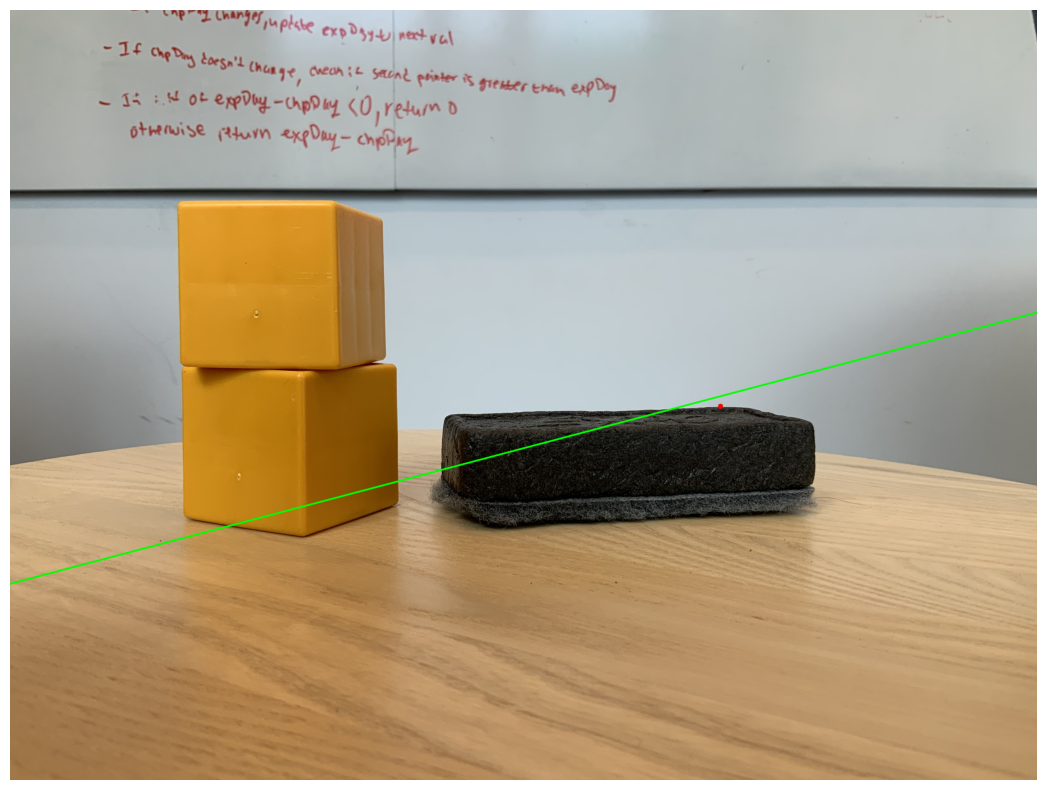

In [18]:
w = img_display1.shape[1]
x0,y0 = map(int, [0, -l_0[2]/l_0[1] ])
x1,y1 = map(int, [w, -(l_0[2]+l_0[0]*w)/l_0[1]])
line_img_test=cv2.line(img_display1, (x0,y0), (x1,y1), (0,255,0),5)
line_img_test=cv2.circle(line_img_test, (int(x_0[0]),int(x_0[1])), 10, (255,0,0), -1)
plt.imshow(line_img_test)
plt.axis('off')

(-0.5, 4031.5, 3023.5, -0.5)

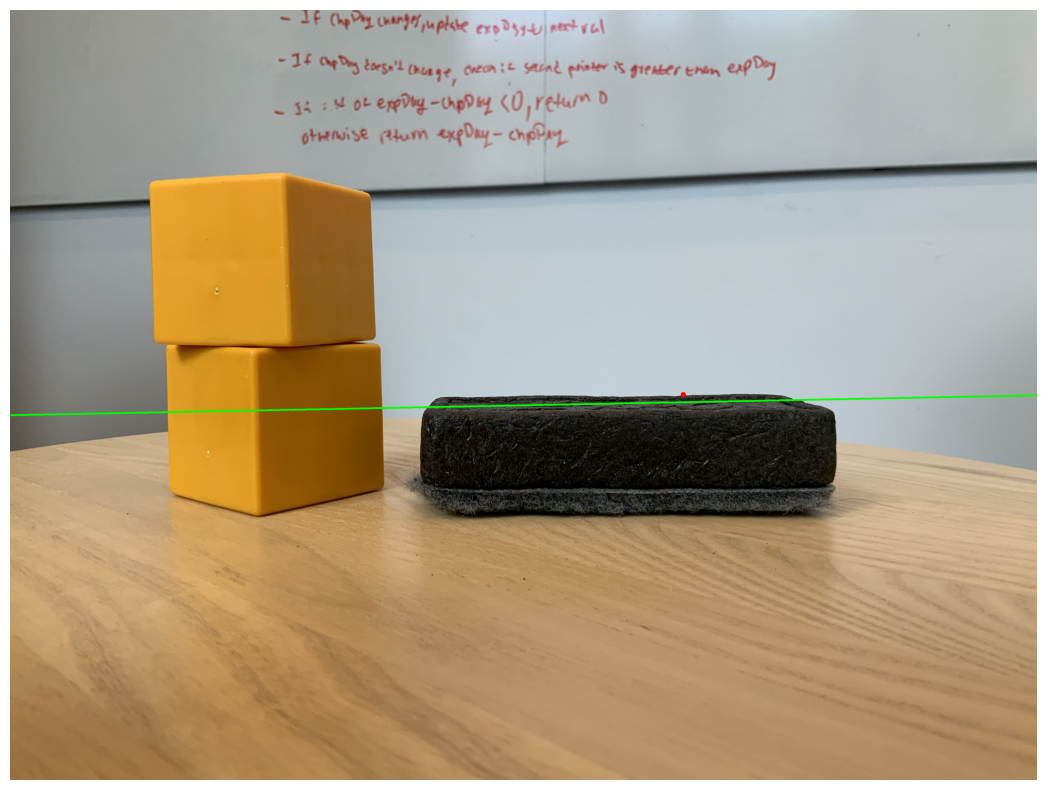

In [19]:
w_b = img_display2.shape[1]
xb0,yb0 = map(int, [0, -l_1[2]/l_1[1] ])
xb1,yb1 = map(int, [w_b, -(l_1[2]+l_1[0]*w_b)/l_1[1]])
line_img_test2=cv2.line(img_display2, (xb0,yb0), (xb1,yb1), (0,255,0),5)
line_img_test2=cv2.circle(line_img_test2, (int(x_1[0]),int(x_1[1])), 10, (255,0,0), -1)
plt.imshow(line_img_test2)
plt.axis('off')

Plotting the remaining lines yields the following

In [20]:
w = img_display1.shape[1]
w_b = img_display2.shape[1]

for m in sorted_matches[:num_keep]:
    # Get feature correspondence coordinates from both frames
    m0 = kpts1[m.queryIdx].pt
    m1 = kpts2[m.trainIdx].pt

    # Construct homogenous vectors x_0 and x_1 based on match coordinates
    x_0 = np.array([m0[0], m0[1], 1])
    x_1 = np.array([m1[0], m1[1], 1])

    # Multiply x_0, x_1 with F, F_transpose based on equations above
    l_0= np.transpose(F).dot(x_1)
    l_1= F.dot(x_0)
    
    
    x0,y0 = map(int, [0, -l_0[2]/l_0[1] ])
    x1,y1 = map(int, [w, -(l_0[2]+l_0[0]*w)/l_0[1]])
    line_img_test=cv2.line(img_display1, (x0,y0), (x1,y1), (0,255,0),5)
    line_img_test=cv2.circle(line_img_test, (int(x_0[0]),int(x_0[1])), 10, (255,0,0), -1)
    
    
    xb0,yb0 = map(int, [0, -l_1[2]/l_1[1] ])
    xb1,yb1 = map(int, [w_b, -(l_1[2]+l_1[0]*w_b)/l_1[1]])
    line_img_test2=cv2.line(img_display2, (xb0,yb0), (xb1,yb1), (0,255,0),5)
    line_img_test2=cv2.circle(line_img_test2, (int(x_1[0]),int(x_1[1])), 10, (255,0,0), -1)

(-0.5, 4031.5, 3023.5, -0.5)

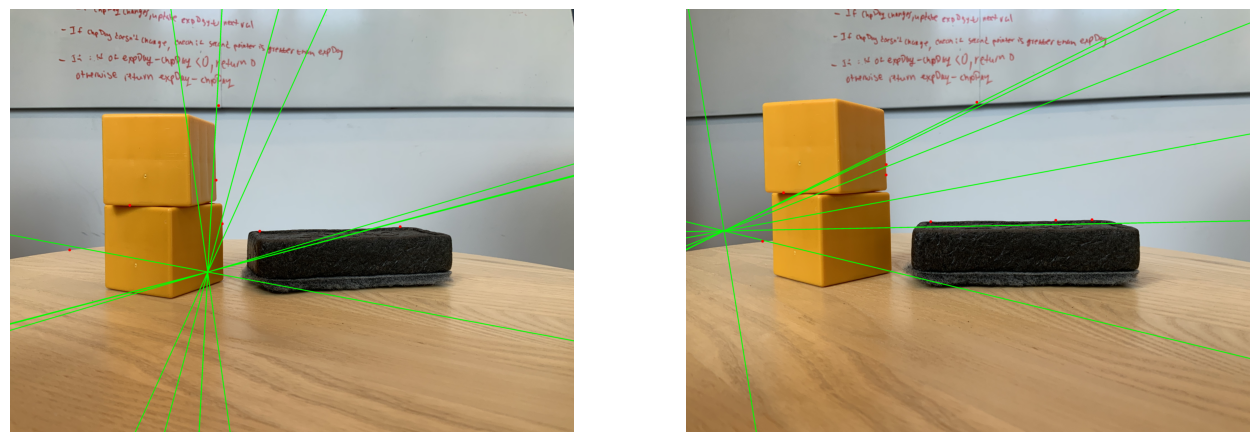

In [21]:
plt.subplot(1,2,1)
plt.imshow(line_img_test)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(line_img_test2)
plt.axis('off')

Though the lines miss a few of the points by a little, their intersections converge at a point, which is a good sign. 

## Section 3: Triangulation

In this section, we first go over triangulation and how it can be used to find 3D points given an epipolar setup with known camera locations. From there, we implement code to carry out a triangulation process based on the estimated epipolar geometry encoded by $\textbf{F}$ from before.

This section is heavily based on Kris Kitani's slides on triangulation (**Lecture 8.5**), alongside **Section 11.2.4** of Szeliski's textbook.

### 3.1: Triangulation - What's (or Rather Where's) the Point?

So remember that "nice" epipolar set up we had before, where lines $l_0$ and $l_1$ align perfectly at $\textbf{p}$ in physical space? While this true within a non-noisy context, this is not usually the case. Given how $l_0$ and $l_1$ are projective 2D lines, it's hard to pinpoint whether the two intersect or overlap each other but never actually touch within 3D space. In other words, distortions and discrepancies between 2D viewframes may warp the percieved location of the point from its actual 3D coordinates. Thus, in obtaining the correct 3D coordinates, we have to correct for these distortions. Triangulation seeks to correct, or rectify, the discrepancies between the percieved 3D location of $p$, $q_0$ and $q_1$, by finding a point $p_t$ in between the two that minimizes the absolute distance between $p_t$ and any $q_i$. 

<img src="triangulation.jpg" width="40%" height="40%"/>

That is, if observers $c_0$ and $c_1$ are arguing over whether $p$ is at $q_0$ or $q_1$ in 3D space, triangulation says that the correct coordinates for $p$ are right in the middle of the two proposed locations. 

Of course, the observer matrices, $\textbf{P}_0$ and $\textbf{P}_1$ have to be known in order to perform triangulation, which we currently don't have. Luckily, if we recall that the essential and fundamental matrices encode information about the positition and rotation of the observer between frames, we can get $\textbf{P}_0$ and $\textbf{P}_1$. 

For an essential matrix $\textbf{E} = [\textbf{t}]_\times\textbf{R}$, where $\textbf{t}$ and $\textbf{R}$ are known. we can set the canonical observer/camera matrices to be $\textbf{P}_0 = [\textbf{I}|\textbf{0}]$ and $\textbf{P}_1 = [\textbf{R}|\textbf{t}]$. 

However, for uncalibrated system, we can't get an explicit rotation matrix or translation vector. Instead, we rely on a homography $\textbf{H}$ and the homogenous coordinate of the epipole in the right/next frame $\textbf{e}'$ to equivalently represent rotation and translation and get the canonical observer/camera matrices  $\textbf{P}_0 = [\textbf{I}|\textbf{0}]$ and $\textbf{P}_1 = [\textbf{H}|\textbf{e}]$.

We will first find the epipole $\textbf{e}$. Recall that we can form the epipolar lines with the expression

<font size="5">
$$\textbf{Fx} = \textbf{l}'$$
<font\>

That is, the feature seen at $\textbf{x}$ in the first corresponds to the line $\textbf{l}'$ in the second frame, i.e. a distance between an invisible observer at the epipole and the feature. However, because there is no percievable distance between the invisible observer and the epipole, there's no line associated with the epipole, i.e. 

<font size="5">
$$\textbf{Fe} = \textbf{0}$$
<font\>

thus forming a homogenous system. To find the epipole $\textbf{e}$, then we perform SVD on $\textbf{F}^T\textbf{F}$ then get the row of $\textbf{V}^T$ corresponding to the smallest singular value in $\textbf{S}$, similarly to solving for $\textbf{f}$ in $\textbf{Af} = \textbf{0}$.

In [22]:
# Perform SVD on F_transpose * F
FtF = np.transpose(F).dot(F)
u_F, s_F, vT_F = np.linalg.svd(F)
print(np.transpose(vT_F))

# Epipole e is represented by eigenvector corresponding to smallest singular value at row i=2
e = vT_F[2]

# The epipole projected to image coordinates, then is
e = e/vT_F[2][2]

print('----')
print(e)

[[ 1.25610907e-03 -7.99438783e-01  6.00746248e-01]
 [-1.47571456e-03  6.00744586e-01  7.99439657e-01]
 [ 9.99998122e-01  1.89071339e-03  4.25142724e-04]]
----
[1.41304605e+03 1.88040301e+03 1.00000000e+00]


Next, we form the homography matrix $H$. As is recommended by Szileski's textbook, we set our homography to be $H = [\textbf{e}]_\times\textbf{F}$, which places the observer/camera on the plane at infinity (i.e. the camera is put at a "vanishing point" of sorts)

In [23]:
# Set up homography using cross product operator on e
e_cross = np.array([[0, -e[2], e[1]],[e[2],0,-e[0]],[-e[1],e[0],0]])

# ... and multiplying that with F
H = e_cross.dot(F)
print(H)

[[-9.52149826e+00  1.11861370e+01 -7.58013013e+03]
 [ 7.15501422e+00 -8.40592432e+00  5.69616077e+03]
 [ 5.27230566e-03 -1.36423658e-03 -4.88469614e+00]]


Now we set up the observer/camera matrices $\textbf{P}_0$ and $\textbf{P}_1$

In [24]:
P_0 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
#print(np.concatenate((H[0], e[0]), axis=None))
P_10 = np.concatenate((H[0], e[0]), axis=None)
P_11 = np.concatenate((H[1], e[1]), axis=None)
P_12 = np.concatenate((H[2], e[2]), axis=None)
P_1 = np.vstack((P_10,P_11,P_12))
print(P_1)

[[-9.52149826e+00  1.11861370e+01 -7.58013013e+03  1.41304605e+03]
 [ 7.15501422e+00 -8.40592432e+00  5.69616077e+03  1.88040301e+03]
 [ 5.27230566e-03 -1.36423658e-03 -4.88469614e+00  1.00000000e+00]]


From here, we can now start implementing our triangulation process. 
We know for our observer/camera matrices $\textbf{P}_0$ and $\textbf{P}_1$ and 3D point $\textbf{X}$, 

<font size="5">
$$\textbf{P}_0\textbf{X} = \textbf{x}_0$$
<font\>

<font size="5">
$$\textbf{P}_1\textbf{X} = \textbf{x}_1$$
<font\>

We can convert the above into a homogenous linear system by taking the cross products of $\textbf{x}_0$ crossed with $\textbf{P}_0$ and $\textbf{x}_1$ crossed with $\textbf{P}_1$ to get

<font size="5">
$$\textbf{x}_i \times \textbf{P}_i\textbf{X} = 0$$
<font\>

for $i = 0,1$ which, when expanded out, yields 

<font size="5">
$$
\begin{bmatrix}x_i\\ y_i\\ 1\end{bmatrix}
\times 
\begin{bmatrix}\textbf{p}^T_1\textbf{X}\\ \textbf{p}^T_2\textbf{X}\\ \textbf{p}^T_3\textbf{X}\end{bmatrix}
=
\begin{bmatrix}
y\textbf{p}^T_3\textbf{X} - \textbf{p}^T_2\textbf{X}\\ 
\textbf{p}^T_1\textbf{X} - x\textbf{p}^T_3\textbf{X}\\  
x\textbf{p}^T_2\textbf{X} - y\textbf{p}^T_1
\end{bmatrix}
$$ 
</font>  

where $\textbf{p}^T_1,\textbf{p}^T_2,\textbf{p}^T_3$ are the rows of $\textbf{P}_i$. Since the third entry in the product is a linear combination, the expression above can be simplified to a homogenous linear system of two equations

<font size="5">
$$
\begin{bmatrix}
y\textbf{p}^T_3 - \textbf{p}^T_2\\ 
\textbf{p}^T_1 - x\textbf{p}^T_3\\  
\end{bmatrix}\textbf{X}
= \textbf{0}
$$ 
</font>  

Since we have two camera matrices, we can expand the above into the follow homogenous linear system of four equations

<font size="5">
$$
\begin{bmatrix}
y\textbf{p}^T_3 - \textbf{p}^T_2\\ 
\textbf{p}^T_1 - x\textbf{p}^T_3\\
y'\textbf{p'}^T_3 - \textbf{p'}^T_2\\ 
\textbf{p'}^T_1 - x'\textbf{p'}^T_3\\  
\end{bmatrix}\textbf{X}
= \textbf{0}
$$ 
</font>

where $\textbf{p}$ denotes the entries of $\textbf{P}$ and $\textbf{p'}$ denotes the entries of $\textbf{P'}$. 

All that is left to do the is to solve for $\textbf{X}$ using SVD, where the entries of $\textbf{X}$ are the entries of the eigenvector row in $\textbf{V}^T$ associated with the smallest singular value in the resulting $\textbf{S}$ matrix, per total least squares. Our implemention is as follows:

In [25]:
# Construct the matrix of cross products A_p
P0_r0 = P_0[0]
P0_r1 = P_0[1]
P0_r2 = P_0[2]

P1_r0 = P_1[0]
P1_r1 = P_1[1]
P1_r2 = P_1[2]


A_p0 = x_0[1]*P0_r2 - P0_r1
A_p1 = P0_r0 - x_0[0]*P0_r2
A_p3 = x_1[1]*P1_r2 - P1_r1
A_p4 = P1_r0 - x_1[0]*P1_r2

A_p = np.array ([A_p0,A_p1,A_p3,A_p4])

print(A_p)

[[ 0.00000000e+00 -1.00000000e+00  1.55664709e+03  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -2.78928711e+03  0.00000000e+00]
 [ 7.85531186e-01  6.35126680e+00 -1.30529329e+04 -3.74317071e+02]
 [-2.48218078e+01  1.51451719e+01  6.59533082e+03 -1.48896884e+03]]


In [26]:
# Perform SVD on A_p
u_ap, s_ap, vT_ap = np.linalg.svd(A_p)

# Set the point_coord = [x,y,z,w] (X) to be last row of V_transpose
# 
point_coord = vT_ap[3]

# Print the resulting point_coord and homogenized point coord (i.e. divide x,y,z entries by w so w'=1)
print(point_coord)
print(point_coord/point_coord[3])

[-7.61197597e-01 -6.48507498e-01 -4.67620419e-04  4.00305970e-03]
[-1.90153946e+02 -1.62002954e+02 -1.16815749e-01  1.00000000e+00]


thus yielding the 3D coordinate for the feature associated with match i = 3. We can repeat this process for the other features to get their estimated relative 3D coordinates.

In [27]:
arr_X = []
for m in sorted_matches[:num_keep]:
    # Get feature correspondence coordinates from both frames
    m0 = kpts1[m.queryIdx].pt
    m1 = kpts2[m.trainIdx].pt

    # Construct homogenous vectors x_0 and x_1 based on match coordinates
    x_0 = np.array([m0[0], m0[1], 1])
    x_1 = np.array([m1[0], m1[1], 1])
    
    # Construct the matrix of cross products A_p
    P0_r0 = P_0[0]
    P0_r1 = P_0[1]
    P0_r2 = P_0[2]

    P1_r0 = P_1[0]
    P1_r1 = P_1[1]
    P1_r2 = P_1[2]


    A_p0 = x_0[1]*P0_r2 - P0_r1
    A_p1 = P0_r0 - x_0[0]*P0_r2
    A_p3 = x_1[1]*P1_r2 - P1_r1
    A_p4 = P1_r0 - x_1[0]*P1_r2

    A_p = np.array ([A_p0,A_p1,A_p3,A_p4])
    
    # Perform SVD on A_p
    u_ap, s_ap, vT_ap = np.linalg.svd(A_p)

    # Set the point_coord (X) to be last row of V_transpose
    point_coord = vT_ap[3]

    arr_X += [point_coord/point_coord[3]] 

print(arr_X)

[array([-3.62814795e+02, -4.19479992e+02, -3.38572115e-01,  1.00000000e+00]), array([-1.84778758e+02, -3.38176008e+02, -2.28091184e-01,  1.00000000e+00]), array([-3.62045864e+01, -1.44975641e+02, -8.45635127e-02,  1.00000000e+00]), array([-4.32802978e+02, -4.96897831e+02, -2.91033459e-01,  1.00000000e+00]), array([-1.57326158e+03, -2.06608360e+03, -1.12568639e+00,  1.00000000e+00]), array([-1.08764515e+03, -1.44793054e+03, -8.30433059e-01,  1.00000000e+00]), array([-5.07541748e+02, -6.76433769e+02, -4.28739144e-01,  1.00000000e+00]), array([-1.90153946e+02, -1.62002954e+02, -1.16815749e-01,  1.00000000e+00])]


If we change the signs for the coordinates above as needed, we can plot them on a 3D coordinate axis where $x$ and $y$ are the image dimesions and $z$ is set between 0 (super close) and 1 (super far) and compare it to the original image.

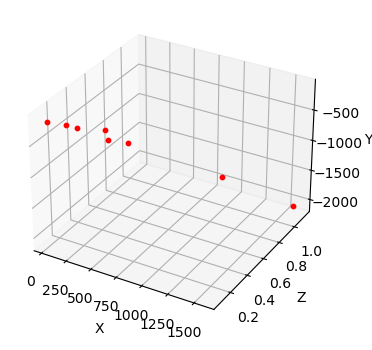

In [32]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for x in arr_X:
    if matcher_type == 'sift':
        ax.scatter(-x[0], -x[2], x[1], c='red', s=10)
    else:
        ax.scatter(x[0], -x[2], -x[1], c='red', s=10)
        
ax.set(xlabel='X', ylabel='Z', zlabel='Y')
plt.show()

(-0.5, 8063.5, 3023.5, -0.5)

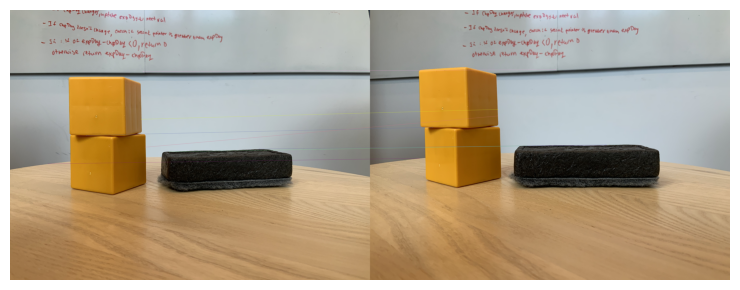

In [29]:
# An image with the keypoint matches to compare with
one_match_img2 = cv2.drawMatches(line_img_test, kpts1, line_img_test2, kpts2, [sorted_matches[i]], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_img)
plt.axis('off')

## Wrap-up

Here, we discuss the results obtained from running the code above, then propose potential changes that could be taken to improve the accuracy of our reconstruction.

### Results Analysis

In running the code on the 'table_stuff' images, it gets 3D coordinates for all 8 feature points identified in either frame. From observing the 3D plots for both SIFT and ORB, the $x,y$ coordinates generally seemed to align with that of the images while the $z$ coordinates aligns with where we would expect the feature points relative to where the camera is. 

However, the coordinate values, and even their signs, wildly differ depending on which keypoint matching algorithm is used, hence our need to convert signs in plotting our results. For example, using the SIFT keypoint matcher yields all negative $x,y,z$ coordinates where $z$ is between 0 and 1 and the $x,y$ ranges corresponded exactly to the $x,y$ pixel dimensions of the input images. However, if the ORB matcher is used, then all the $x,y,z$ coordinates are positively valued, where $z$ is still between 0 and 1 but the $x,y$ ranges are proportional to, but don't correspond exactly with, the $x,y$ pixel dimensions of the input images. 

While we are not fully sure why we get these varying signs and values, one hypothesis we have is that each of keypoint matchers yield different 2D epipole coordinates on the images. For SIFT on the 'table_stuff' images, the epipole was determined to be within the frame, as evidenced by the visible intersection of the epipolar lines at a singular point. Meanwhile, the epipole was determined to be outside the frame when the ORB matcher was used, as evidenced by the lack of a visible intersection point. This in-frame, out-of-frame characteristic could have influenced whether or not the coordinates would be positive or negative. Additionally, the norms used by either matcher might have also contributed to the varying proportionality between the 2D and 3D coordinates. While SIFT utilizes an L1 norm to obtain image coordinates, our ORB matcher uses a Hamming Norm, which may have changed the scaling of coordinates between the orginal pixel scale and our final 3D coordinate scale. 

### Potential Changes/Add-ons

Though the results produced above are satisfactory for the purposes of this demo, there are many changes that could be made to improve the correctness and accuracy of the reconstruction. One change that could be made is to use more image frames to represent the scene. This would provide many more camera matrices on which we could do iterative triangulation, thus potentially yielding more accurate 3D coordinates. Another change that could significantly improve the reconstruction would be to include scene calibration. That is, we provide a means of inputting the scene dimensions as well as additional information on translation and rotation from which an essential matrix can be formed. This essential matrix can then be used to obtain a more accurate and prorportional 3D plot than the one we got. Moreover, having done testing on various different pairs of images, it id important to note that using more textures surfaces helps in acquiring more keypoints. This goes hand in hand in ensuring that the scene captured does not have any overly-glossy surfaces as glossy surfaces may result in reflections that may confuse the keypoint detector and, in cases of the application of the 8-point algorithm, go ahead and ruin egomotion. Regardless of the final results, we hope that this demo provides readers with more background knowledge on the 3D scene reconstruction process. Hopefully, this notebook inspires others to experiment with 3D reconstruction methods like the Eight-Point Algorithm. 